# Autoencoder (AE) for Anomaly Detection

**by Rick Qiu in May, 2020**

In [36]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [37]:
import random
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
# Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adagrad, Adam
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, Dropout, LSTM
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.keras import regularizers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
%matplotlib inline

### Data generation

In [38]:
# We refer alphabetic character sequence generation to Alon Agmon 2020
# https://github.com/a-agmon/experiments/blob/master/Sequence_Anomaly_Detection-NN.ipynb
def get_random_string():
    # returns a string of the following format: 
    #[4 letters A-F][1 digit 0-2][3 letters QWOPZXML]
    first_letters =  'ABCDEF'
    second_numbers = '120'
    last_letters = 'QWOPZXML'
    str1 = ''.join(random.choice(first_letters) for i in range(4))
    str2 = random.choice(second_numbers)
    str3 = ''.join(random.choice(last_letters) for i in range(3))
    return str1+str2+str3
    
print(get_random_string())

BECE2QXZ


In [39]:
def generate_data():
    normals = 50000 - 10
    random_sequences = [get_random_string() for i in range(normals)]
    # add some anomalies to our list
    random_sequences.extend(['XYDC2DCA', 'TXSX1ABC','RNIU4XRE','AABDXUEI','SDRAC5RF',
                             'YXDC2DCB', 'XTSX1ABC','RNUI4XRE','TABDXAID','SERACDRF'])
    return random_sequences

In [40]:
data = generate_data()
print(data[0:5])

['DEDB1ZOQ', 'CCEE1MOL', 'CBBA1PWX', 'FEEC0WQW', 'EFBD0PMQ']


### Data Preprocessing

In [41]:
# We refer sequence encoding and decoding to Alon Agmon 2020
# https://github.com/a-agmon/experiments/blob/master/Sequence_Anomaly_Detection-NN.ipynb
#Build the char index that we will use to encode seqs to numbers
char_index = '0abcdefghijklmnopqrstuvwxyz'
char_index +='ABCDEFGHIJKLMNOPQRSTUVWXYZ'
char_index += '123456789'
char_index += '().,-/+=&$?@#!*:;_[]|%⸏{}\"\'' + ' ' +'\\'

char_to_int = dict((c, i) for i, c in enumerate(char_index))
int_to_char = dict((i, c) for i, c in enumerate(char_index))

#function that convert a char seqs to numbers seqs 
#(it does a little more but lets leave it for now)
def encode_sequence_list(seqs, feat_n=0):
    encoded_seqs = []
    for seq in seqs:
        encoded_seq = [char_to_int[c] for c in seq]
        encoded_seqs.append(encoded_seq)
    if(feat_n > 0):
        encoded_seqs.append(np.zeros(feat_n))
    return pad_sequences(encoded_seqs, padding='post')

def decode_sequence_list(seqs):
    decoded_seqs = []
    for seq in seqs:
        decoded_seq = [int_to_char[i] for i in seq]
        decoded_seqs.append(decoded_seq)
    return decoded_seqs

In [42]:
# encode each string seq to an integer array [[1],[5],[67]], [[45],[76],[7]
encoded_seqs = encode_sequence_list(data)
# mix everything up
np.random.shuffle(encoded_seqs)
print(encoded_seqs.shape)
print(encoded_seqs[10])

(50000, 8)
[27 30 27 27 54 52 52 42]


In [43]:
# split dataset to train/test (80:20)
X_train = encoded_seqs[:40000]
X_test = encoded_seqs[40000:]

# scale the data to a range [0.1]
scaler = MinMaxScaler()
scaler = scaler.fit(X_train)
scaled_train  = scaler.transform(X_train)
scaled_test = scaler.transform(X_test)

### Autoencoder Model

In [44]:
# Define the autoencoder
def autoencoder_model():
    # Encoder
    input_data = Input(shape=(8,))
    encoder = Dense(units=5,activation='relu')(input_data)
    # Bottleneck
    latent_output = Dense(units=2,activation='relu')(encoder)
    # Decoder
    decoder = Dense(units=5,activation='relu')(latent_output)
    decoder = Dense(units=8,activation='linear')(decoder)
    # Create Autoencoder model
    autoencoder = Model(input_data,decoder)
    return autoencoder

In [45]:
# Define a function which plots training loss and validation loss across the different epochs.
def plot_loss(history):
    plt.xlabel('Epochs')
    plt.ylabel('MSE')
    # Plot train loss
    plt.plot(history.history["loss"], linewidth=2., label="train_loss")
    # Plot val_loss
    plt.plot(history.history["val_loss"],linewidth=2., label="val_loss")
    plt.legend()
    plt.show()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 8)]               0         
_________________________________________________________________
dense_8 (Dense)              (None, 5)                 45        
_________________________________________________________________
dense_9 (Dense)              (None, 2)                 12        
_________________________________________________________________
dense_10 (Dense)             (None, 5)                 15        
_________________________________________________________________
dense_11 (Dense)             (None, 8)                 48        
Total params: 120
Trainable params: 120
Non-trainable params: 0
_________________________________________________________________
None


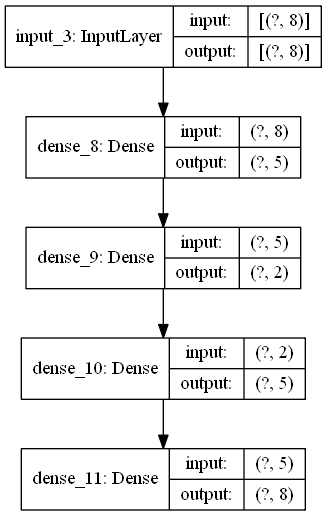

In [46]:
# Instantiate and compile the model
autoencoder = autoencoder_model()
opt = Adam(learning_rate=0.001, decay=1e-5)
autoencoder.compile(optimizer=opt,loss='mean_squared_error')
print(autoencoder.summary())
plot_model(autoencoder, to_file='autoencoder.png', show_shapes=True)

### Model Training

In [47]:
epochs=100
batch_size = 128


checkpointer = ModelCheckpoint(filepath="ae_model.h5",
                               verbose=0,
                               save_best_only=True)

tensorboard = TensorBoard(log_dir='logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)

history = autoencoder.fit(scaled_train, scaled_train,
                epochs=epochs,
                batch_size=batch_size,
                shuffle=True,
                verbose = 1,
                validation_data=(scaled_test, scaled_test),
                callbacks=[checkpointer, tensorboard])

Train on 40000 samples, validate on 10000 samples
Epoch 1/100
40000/40000 [==============================] - 1s 21us/sample - loss: 0.1711 - val_loss: 0.1099
Epoch 2/100
40000/40000 [==============================] - 0s 11us/sample - loss: 0.0795 - val_loss: 0.0588
Epoch 3/100
40000/40000 [==============================] - 0s 11us/sample - loss: 0.0434 - val_loss: 0.0283
Epoch 4/100
40000/40000 [==============================] - 0s 11us/sample - loss: 0.0232 - val_loss: 0.0201
Epoch 5/100
40000/40000 [==============================] - 0s 11us/sample - loss: 0.0187 - val_loss: 0.0181
Epoch 6/100
40000/40000 [==============================] - 0s 11us/sample - loss: 0.0176 - val_loss: 0.0177
Epoch 7/100
40000/40000 [==============================] - 0s 11us/sample - loss: 0.0174 - val_loss: 0.0176
Epoch 8/100
40000/40000 [==============================] - 0s 11us/sample - loss: 0.0174 - val_loss: 0.0176
Epoch 9/100
40000/40000 [==============================] - 0s 11us/sample - loss: 0.01

Epoch 76/100
40000/40000 [==============================] - 0s 10us/sample - loss: 0.0123 - val_loss: 0.0125
Epoch 77/100
40000/40000 [==============================] - 0s 10us/sample - loss: 0.0123 - val_loss: 0.0125
Epoch 78/100
40000/40000 [==============================] - 0s 10us/sample - loss: 0.0123 - val_loss: 0.0125
Epoch 79/100
40000/40000 [==============================] - 0s 11us/sample - loss: 0.0123 - val_loss: 0.0125
Epoch 80/100
40000/40000 [==============================] - 0s 10us/sample - loss: 0.0123 - val_loss: 0.0125
Epoch 81/100
40000/40000 [==============================] - 0s 10us/sample - loss: 0.0123 - val_loss: 0.0125
Epoch 82/100
40000/40000 [==============================] - 0s 10us/sample - loss: 0.0123 - val_loss: 0.0125
Epoch 83/100
40000/40000 [==============================] - 0s 10us/sample - loss: 0.0123 - val_loss: 0.0125
Epoch 84/100
40000/40000 [==============================] - 0s 11us/sample - loss: 0.0123 - val_loss: 0.0125
Epoch 85/100
40000/

Result: 
Train loss:0.012314, Val loss:0.012473


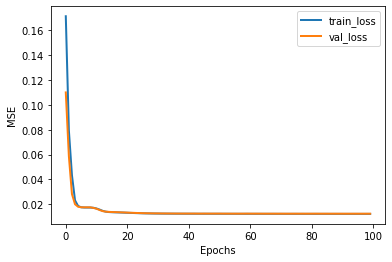

In [48]:
print ("Result: \nTrain loss:%f, Val loss:%f" % (history.history["loss"][epochs-1], history.history["val_loss"][epochs-1]))
# Make Train Loss and Validation Loss versus Epochs plot 
plot_loss(history)

### Threshold Selection

In [49]:
autoencoder = load_model('ae_model.h5')

In [50]:
# compute reconstruction errors on train set
predictions = autoencoder.predict(scaled_train)
mse = np.mean(np.power(scaled_train - predictions, 2), axis=1)
threshold = np.quantile(mse, (1-10/50000))
print('MSE threshold:', threshold)

MSE threshold: 0.029984053585163612


### Prediction

In [51]:
# predict on test set
predictions = autoencoder.predict(scaled_test)
mse = np.mean(np.power(scaled_test - predictions, 2), axis=1)
a = np.array(mse)
anoms_idx = np.argwhere(a > threshold)
anomalies = X_test[anoms_idx]
for anom in anomalies:
    print(decode_sequence_list(anom)[0])

['R', 'N', 'U', 'I', '4', 'X', 'R', 'E']
['X', 'Y', 'D', 'C', '2', 'D', 'C', 'A']


### TensorBoard

In [66]:
# Load the TensorBoard notebook extension
#%load_ext tensorboard

In [67]:
#%tensorboard --logdir logs